# Group Assignment 4: Spatial Analysis

## Structure of the combined notebook:

### Filtering & Joining the Data
Joining the expulsion dataset from the midterm to include the racial/ethnic breakdown.

### Normalizing the Data
I would like to produce several heatmaps with the following normalized data:
* % Total students expelled
* % Total students expelled who are Black
* % of Black students who are expelled
* Repeat the latter two heatmaps for all racial/ethnic groups

### Spatial Analysis
Following the prompt: "Conduct a thorough point pattern analysis of your dataset. Your notebook should include a KDE plot, as well as a centrography analysis, indicating central tendencies of your data (mean, median, ellipse). Include different "slices" of your data to produce meaningful results (e.g. kde plots for different categorical values)."

In [6]:
# the usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy as np

## School Expulsion Data Joining & Filtering

### Import the Data

In [7]:
# import the school expulsion data including geodataframe
expgdf_geometry = gpd.read_file('exp1920_TA_gdf.geojson')

# next, import the school expulsion data including racial breakdown
expgdf = gpd.read_file('exp1920_RC.csv')

In [8]:
expgdf.head()

AcademicYear AggregateLevel CountyCode DistrictCode SchoolCode   CountyName  \
0      2019-20              S         19        64212    1995596  Los Angeles   
1      2019-20              S         19        64212    1995596  Los Angeles   
2      2019-20              S         19        64212    1995596  Los Angeles   
3      2019-20              S         19        64212    1995596  Los Angeles   
4      2019-20              S         19        64212    1995596  Los Angeles   

  DistrictName                   SchoolName CharterYN ReportingCategory  ...  \
0  ABC Unified  ABC Secondary (Alternative)       No                 GF  ...   
1  ABC Unified  ABC Secondary (Alternative)       No                 GM  ...   
2  ABC Unified  ABC Secondary (Alternative)       No                 RA  ...   
3  ABC Unified  ABC Secondary (Alternative)       No                 RB  ...   
4  ABC Unified  ABC Secondary (Alternative)       No                 RD  ...   

  Unduplicated Count of Students Expelled (Total)  \
0                                               0   
1                                               0   
2                                               *   
3                                               *   
4                                               *   

  Unduplicated Count of Students Expelled (Defiance-Only)  \
0                                                  0        
1                                                  0        
2                                                  *        
3                                                  *        
4                                                  *        

  Expulsion Rate (Total) Expulsion Count Violent Incident (Injury)  \
0                      0                                         0   
1                      0                                         0   
2                      *                                         *   
3                      *                                         *   
4                      *                                         *   

  Expulsion Count Violent Incident (No Injury)  \
0                                            0   
1                                            0   
2                                            *   
3                                            *   
4                                            *   

  Expulsion Count Weapons Possession Expulsion Count Illicit Drug-Related  \
0                                  0                                    0   
1                                  0                                    0   
2                                  *                                    *   
3                                  *                                    *   
4                                  *                                    *   

  Expulsion Count Defiance-Only Expulsion Count Other Reasons geometry  
0                             0                             0     None  
1                             0                             0     None  
2                             *                             *     None  
3                             *                             *     None  
4                             *                             *     None  

[5 rows x 22 columns]

In [9]:
# check the column names
expgdf.columns

Index(['AcademicYear', 'AggregateLevel', 'CountyCode', 'DistrictCode',
       'SchoolCode', 'CountyName', 'DistrictName', 'SchoolName', 'CharterYN',
       'ReportingCategory', 'CumulativeEnrollment', 'Total Expulsions',
       'Unduplicated Count of Students Expelled (Total)',
       'Unduplicated Count of Students Expelled (Defiance-Only)',
       'Expulsion Rate (Total)', 'Expulsion Count Violent Incident (Injury)',
       'Expulsion Count Violent Incident (No Injury)',
       'Expulsion Count Weapons Possession',
       'Expulsion Count Illicit Drug-Related', 'Expulsion Count Defiance-Only',
       'Expulsion Count Other Reasons', 'geometry'],
      dtype='object')

In [10]:
# check the types of each column
expgdf_geometry.info()
expgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 45 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   DistrictName                                             154 non-null    object  
 1   SchoolName                                               154 non-null    object  
 2   CharterYN                                                154 non-null    object  
 3   ReportingCategory                                        154 non-null    object  
 4   CumulativeEnrollment                                     154 non-null    object  
 5   Total Expulsions                                         154 non-null    int64   
 6   Unduplicated Count of Students Expelled (Total)          154 non-null    int64   
 7   Unduplicated Count of Students Expelled (Defiance-Only)  154 non-null    int64   
 8   Expulsion Ra

### Clean the Expulsion Data

In [11]:
# ensure that all the County Code, District Code, and School Code columns have the correct amount of characters by filling in leading 0's
expgdf['CountyCode'] = expgdf['CountyCode'].str.zfill(2)
expgdf['DistrictCode'] = expgdf['DistrictCode'].str.zfill(5)
expgdf['SchoolCode'] = expgdf['SchoolCode'].str.zfill(7)

In [12]:
# add a column that concatenates the County Code, District Code, and School Code to get a new 'CDSCode' that will match the other dataset.
expgdf['CDSCode'] = expgdf['CountyCode'] + expgdf['DistrictCode'] + expgdf['SchoolCode']

expgdf.info()
expgdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39181 entries, 0 to 39180
Data columns (total 23 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   AcademicYear                                             39181 non-null  object  
 1   AggregateLevel                                           39181 non-null  object  
 2   CountyCode                                               39181 non-null  object  
 3   DistrictCode                                             39181 non-null  object  
 4   SchoolCode                                               39181 non-null  object  
 5   CountyName                                               39181 non-null  object  
 6   DistrictName                                             39181 non-null  object  
 7   SchoolName                                               39181 non-null  object  
 8   CharterY

AcademicYear AggregateLevel CountyCode DistrictCode SchoolCode   CountyName  \
0      2019-20              S         19        64212    1995596  Los Angeles   
1      2019-20              S         19        64212    1995596  Los Angeles   
2      2019-20              S         19        64212    1995596  Los Angeles   
3      2019-20              S         19        64212    1995596  Los Angeles   
4      2019-20              S         19        64212    1995596  Los Angeles   

  DistrictName                   SchoolName CharterYN ReportingCategory  ...  \
0  ABC Unified  ABC Secondary (Alternative)       No                 GF  ...   
1  ABC Unified  ABC Secondary (Alternative)       No                 GM  ...   
2  ABC Unified  ABC Secondary (Alternative)       No                 RA  ...   
3  ABC Unified  ABC Secondary (Alternative)       No                 RB  ...   
4  ABC Unified  ABC Secondary (Alternative)       No                 RD  ...   

  Unduplicated Count of Students Expelled (Defiance-Only)  \
0                                                  0        
1                                                  0        
2                                                  *        
3                                                  *        
4                                                  *        

  Expulsion Rate (Total) Expulsion Count Violent Incident (Injury)  \
0                      0                                         0   
1                      0                                         0   
2                      *                                         *   
3                      *                                         *   
4                      *                                         *   

  Expulsion Count Violent Incident (No Injury)  \
0                                            0   
1                                            0   
2                                            *   
3                                            *   
4                                            *   

  Expulsion Count Weapons Possession Expulsion Count Illicit Drug-Related  \
0                                  0                                    0   
1                                  0                                    0   
2                                  *                                    *   
3                                  *                                    *   
4                                  *                                    *   

  Expulsion Count Defiance-Only Expulsion Count Other Reasons geometry  \
0                             0                             0     None   
1                             0                             0     None   
2                             *                             *     None   
3                             *                             *     None   
4                             *                             *     None   

          CDSCode  
0  19642121995596  
1  19642121995596  
2  19642121995596  
3  19642121995596  
4  19642121995596  

[5 rows x 23 columns]

In [13]:
# replace all '*' entries as 0 (making an assumption)
expgdf = expgdf.replace('*',0)
expgdf.head()

AcademicYear AggregateLevel CountyCode DistrictCode SchoolCode   CountyName  \
0      2019-20              S         19        64212    1995596  Los Angeles   
1      2019-20              S         19        64212    1995596  Los Angeles   
2      2019-20              S         19        64212    1995596  Los Angeles   
3      2019-20              S         19        64212    1995596  Los Angeles   
4      2019-20              S         19        64212    1995596  Los Angeles   

  DistrictName                   SchoolName CharterYN ReportingCategory  ...  \
0  ABC Unified  ABC Secondary (Alternative)       No                 GF  ...   
1  ABC Unified  ABC Secondary (Alternative)       No                 GM  ...   
2  ABC Unified  ABC Secondary (Alternative)       No                 RA  ...   
3  ABC Unified  ABC Secondary (Alternative)       No                 RB  ...   
4  ABC Unified  ABC Secondary (Alternative)       No                 RD  ...   

  Unduplicated Count of Students Expelled (Defiance-Only)  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

  Expulsion Rate (Total) Expulsion Count Violent Incident (Injury)  \
0                      0                                         0   
1                      0                                         0   
2                      0                                         0   
3                      0                                         0   
4                      0                                         0   

  Expulsion Count Violent Incident (No Injury)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

  Expulsion Count Weapons Possession Expulsion Count Illicit Drug-Related  \
0                                  0                                    0   
1                                  0                                    0   
2                                  0                                    0   
3                                  0                                    0   
4                                  0                                    0   

  Expulsion Count Defiance-Only Expulsion Count Other Reasons geometry  \
0                             0                             0     None   
1                             0                             0     None   
2                             0                             0     None   
3                             0                             0     None   
4                             0                             0     None   

          CDSCode  
0  19642121995596  
1  19642121995596  
2  19642121995596  
3  19642121995596  
4  19642121995596  

[5 rows x 23 columns]

In [14]:
# expulsion counts and CDSCode should be expressed as int
int_indices = [11,12,13,15,16,17,18,19,20,22]
for x in int_indices:
    expgdf.iloc[:,x] = expgdf.iloc[:,x].astype(int)
    
# expulsion rate should be expressed as a float
expgdf.iloc[:,14] = expgdf.iloc[:,14].astype(float)

expgdf.dtypes

AcademicYear                                                 object
AggregateLevel                                               object
CountyCode                                                   object
DistrictCode                                                 object
SchoolCode                                                   object
CountyName                                                   object
DistrictName                                                 object
SchoolName                                                   object
CharterYN                                                    object
ReportingCategory                                            object
CumulativeEnrollment                                         object
Total Expulsions                                              int64
Unduplicated Count of Students Expelled (Total)               int64
Unduplicated Count of Students Expelled (Defiance-Only)       int64
Expulsion Rate (Total)                          

### Filter the Expulsion Data
Now that our data is appropriately typed, we can filter them based on value. However, I'm not convinced that the dataset is very complete. I will have to be picky about how to display the data that's incomplete.

Here are each of the reporting categories:

    RB = African American
    RI = American Indian or Alaska Native
    RA = Asian
    RF = Filipino
    RH = Hispanic or Latino
    RD = Not Reported
    RP = Pacific Islander
    RT = Two or More Races
    RW = White
    GM = Male
    GF = Female
    SE = English Learners
    SD = Students with Disabilities
    SS = Socioeconomically Disadvantaged
    SM = Migrant
    SF = Foster
    SH = Homeless
    TA = Total


In [15]:
# Check which entries have values
expgdf['ReportingCategory'].value_counts()

RT    2310
RA    2310
RB    2310
RD    2310
RF    2310
RH    2310
RI    2310
RP    2310
RW    2310
TA    2310
SD    2305
GM    2300
SS    2299
GF    2290
SE    2283
SF    2016
SH    1994
SM     551
GX      43
Name: ReportingCategory, dtype: int64

#### Filtering by Race

In [16]:
# noting that only the race reporting categories are complete (2310 entries), keep the row if it is in total race reporting categories
RaceReportingCategories = ['RB','RI','RA','RF','RH','RD','RP','RT','RW','TA']
expgdf_filtered_race = expgdf[expgdf['ReportingCategory'].isin(RaceReportingCategories)]
expgdf_filtered_race.head()

AcademicYear AggregateLevel CountyCode DistrictCode SchoolCode   CountyName  \
2      2019-20              S         19        64212    1995596  Los Angeles   
3      2019-20              S         19        64212    1995596  Los Angeles   
4      2019-20              S         19        64212    1995596  Los Angeles   
5      2019-20              S         19        64212    1995596  Los Angeles   
6      2019-20              S         19        64212    1995596  Los Angeles   

  DistrictName                   SchoolName CharterYN ReportingCategory  ...  \
2  ABC Unified  ABC Secondary (Alternative)       No                 RA  ...   
3  ABC Unified  ABC Secondary (Alternative)       No                 RB  ...   
4  ABC Unified  ABC Secondary (Alternative)       No                 RD  ...   
5  ABC Unified  ABC Secondary (Alternative)       No                 RF  ...   
6  ABC Unified  ABC Secondary (Alternative)       No                 RH  ...   

  Unduplicated Count of Students Expelled (Defiance-Only)  \
2                                                  0        
3                                                  0        
4                                                  0        
5                                                  0        
6                                                  0        

   Expulsion Rate (Total)  Expulsion Count Violent Incident (Injury)  \
2                     0.0                                          0   
3                     0.0                                          0   
4                     0.0                                          0   
5                     0.0                                          0   
6                     0.0                                          0   

   Expulsion Count Violent Incident (No Injury)  \
2                                             0   
3                                             0   
4                                             0   
5                                             0   
6                                             0   

   Expulsion Count Weapons Possession  Expulsion Count Illicit Drug-Related  \
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   
5                                   0                                     0   
6                                   0                                     0   

   Expulsion Count Defiance-Only  Expulsion Count Other Reasons  geometry  \
2                              0                              0      None   
3                              0                              0      None   
4                              0                              0      None   
5                              0                              0      None   
6                              0                              0      None   

          CDSCode  
2  19642121995596  
3  19642121995596  
4  19642121995596  
5  19642121995596  
6  19642121995596  

[5 rows x 23 columns]

#### Filtering by Nonzero Counts

In [17]:
# filter the full race dataset for entries that are present in this filtered dataset
expgdf_filtered_race_nonzero = expgdf_filtered_race[expgdf_filtered_race['CDSCode'].isin(expgdf_geometry['CDSCode'])]
expgdf_filtered_race_nonzero.reset_index(inplace = True)
expgdf_filtered_race_nonzero.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 24 columns):
 #   Column                                                   Non-Null Count  Dtype   
---  ------                                                   --------------  -----   
 0   index                                                    1540 non-null   int64   
 1   AcademicYear                                             1540 non-null   object  
 2   AggregateLevel                                           1540 non-null   object  
 3   CountyCode                                               1540 non-null   object  
 4   DistrictCode                                             1540 non-null   object  
 5   SchoolCode                                               1540 non-null   object  
 6   CountyName                                               1540 non-null   object  
 7   DistrictName                                             1540 non-null   object  
 8   SchoolName

### Merge the Expulsion by Race Data with Overall Expulsion Data

In [18]:
# check the size of each dataset
print(expgdf_filtered_race_nonzero.shape)
print(expgdf_geometry.shape)

# merge the datasets
expgdf_race = expgdf_filtered_race_nonzero.merge(expgdf_geometry, # left dataset = expulsions, right dataset = geometries
                                                    on='CDSCode', # the column to merge with
                                                    how='left', # use a left outer join, which means all of the entries in expulsions will be preserved
                                                    indicator=True) # create a new column '_merge' that tells us how the merge went

# check the size of each dataset
print(expgdf_filtered_race_nonzero.shape)
print(expgdf_geometry.shape)
print(expgdf_race.shape)

(1540, 24)
(154, 45)
(1540, 24)
(154, 45)
(1540, 69)


In [19]:
# check if the merge was successful (if all the _merge values are 'both')
expgdf_race._merge.value_counts()

both          1540
left_only        0
right_only       0
Name: _merge, dtype: int64

In [20]:
# do a spot check with duplicate rows to make sure that the school names are identical between the school directory and the expulsion dataset
print("\n****School Name****\n")
print(expgdf_race['SchoolName_x'])
print(expgdf_race['SchoolName_y'])
print("\n****District Name****\n")
print(expgdf_race['DistrictName_x'])
print(expgdf_race['DistrictName_y'])


****School Name****

0       Alhambra High
1       Alhambra High
2       Alhambra High
3       Alhambra High
4       Alhambra High
            ...      
1535     Castaic High
1536     Castaic High
1537     Castaic High
1538     Castaic High
1539     Castaic High
Name: SchoolName_x, Length: 1540, dtype: object
0       Alhambra High
1       Alhambra High
2       Alhambra High
3       Alhambra High
4       Alhambra High
            ...      
1535     Castaic High
1536     Castaic High
1537     Castaic High
1538     Castaic High
1539     Castaic High
Name: SchoolName_y, Length: 1540, dtype: object

****District Name****

0                 Alhambra Unified
1                 Alhambra Unified
2                 Alhambra Unified
3                 Alhambra Unified
4                 Alhambra Unified
                   ...            
1535    William S. Hart Union High
1536    William S. Hart Union High
1537    William S. Hart Union High
1538    William S. Hart Union High
1539    William S. Hart 

In [21]:
expgdf_race.columns

Index(['index', 'AcademicYear', 'AggregateLevel', 'CountyCode', 'DistrictCode',
       'SchoolCode', 'CountyName', 'DistrictName_x', 'SchoolName_x',
       'CharterYN_x', 'ReportingCategory_x', 'CumulativeEnrollment_x',
       'Total Expulsions_x',
       'Unduplicated Count of Students Expelled (Total)_x',
       'Unduplicated Count of Students Expelled (Defiance-Only)_x',
       'Expulsion Rate (Total)_x',
       'Expulsion Count Violent Incident (Injury)_x',
       'Expulsion Count Violent Incident (No Injury)_x',
       'Expulsion Count Weapons Possession_x',
       'Expulsion Count Illicit Drug-Related_x',
       'Expulsion Count Defiance-Only_x', 'Expulsion Count Other Reasons_x',
       'geometry_x', 'CDSCode', 'DistrictName_y', 'SchoolName_y',
       'CharterYN_y', 'ReportingCategory_y', 'CumulativeEnrollment_y',
       'Total Expulsions_y',
       'Unduplicated Count of Students Expelled (Total)_y',
       'Unduplicated Count of Students Expelled (Defiance-Only)_y',
       'Ex

In [22]:
# delete some columns
new_columns = ['index', 'AcademicYear', 'AggregateLevel', 'CountyName', 'DistrictName_x', 'SchoolName_x',
       'ReportingCategory_x', 'CumulativeEnrollment_x',
       'Total Expulsions_x',
       'Unduplicated Count of Students Expelled (Total)_x',
       'Unduplicated Count of Students Expelled (Defiance-Only)_x',
       'Expulsion Rate (Total)_x',
       'Expulsion Count Violent Incident (Injury)_x',
       'Expulsion Count Violent Incident (No Injury)_x',
       'Expulsion Count Weapons Possession_x',
       'Expulsion Count Illicit Drug-Related_x',
       'Expulsion Count Defiance-Only_x', 'Expulsion Count Other Reasons_x',
        # these below columns are all from the total counts & geometry
        'CDSCode', 'CumulativeEnrollment_y',
       'Total Expulsions_y',
       'Unduplicated Count of Students Expelled (Total)_y',
       'Unduplicated Count of Students Expelled (Defiance-Only)_y',
       'Expulsion Rate (Total)_y',
       'Expulsion Count Violent Incident (Injury)_y',
       'Expulsion Count Violent Incident (No Injury)_y',
       'Expulsion Count Weapons Possession_y',
       'Expulsion Count Illicit Drug-Related_y',
       'Expulsion Count Defiance-Only_y', 'Expulsion Count Other Reasons_y',
       'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'DOC', 'DOCType',
       'SOC', 'SOCType', 'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName',
       'GSoffered', 'GSserved', 'Virtual', 'Magnet', 'YearRoundYN', 'Latitude',
       'Longitude', 'geometry_y']

expgdf_race = expgdf_race[new_columns]

In [23]:
# delete some columns
new_columns = ['index', 'AcademicYear', 'AggregateLevel', 'CountyName', 'DistrictName', 'SchoolName',
       'ReportingCategory', 'CumulativeEnrollment_R',
       'Total Expulsions_R',
       'Unduplicated Count of Students Expelled (Total)_R',
       'Unduplicated Count of Students Expelled (Defiance-Only)_R',
       'Expulsion Rate (Total)_R',
       'Expulsion Count Violent Incident (Injury)_R',
       'Expulsion Count Violent Incident (No Injury)_R',
       'Expulsion Count Weapons Possession_R',
       'Expulsion Count Illicit Drug-Related_R',
       'Expulsion Count Defiance-Only_Race', 'Expulsion Count Other Reasons_R',
        'CDSCode', 'CumulativeEnrollment_TA',
       'Total Expulsions_TA',
       'Unduplicated Count of Students Expelled (Total)_TA',
       'Unduplicated Count of Students Expelled (Defiance-Only)_TA',
       'Expulsion Rate (Total)_TA',
       'Expulsion Count Violent Incident (Injury)_TA',
       'Expulsion Count Violent Incident (No Injury)_TA',
       'Expulsion Count Weapons Possession_TA',
       'Expulsion Count Illicit Drug-Related_TA',
       'Expulsion Count Defiance-Only_TA', 'Expulsion Count Other Reasons_TA',
       'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'DOC', 'DOCType',
       'SOC', 'SOCType', 'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName',
       'GSoffered', 'GSserved', 'Virtual', 'Magnet', 'YearRoundYN', 'Latitude',
       'Longitude', 'geometry']

expgdf_race.columns = new_columns
expgdf_race.info()
expgdf_race.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 1539
Data columns (total 56 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   index                                                       1540 non-null   int64   
 1   AcademicYear                                                1540 non-null   object  
 2   AggregateLevel                                              1540 non-null   object  
 3   CountyName                                                  1540 non-null   object  
 4   DistrictName                                                1540 non-null   object  
 5   SchoolName                                                  1540 non-null   object  
 6   ReportingCategory                                           1540 non-null   object  
 7   CumulativeEnrollment_R                                      1540 non-null   ob

index AcademicYear AggregateLevel   CountyName      DistrictName  \
0    828      2019-20              S  Los Angeles  Alhambra Unified   
1    829      2019-20              S  Los Angeles  Alhambra Unified   
2    830      2019-20              S  Los Angeles  Alhambra Unified   
3    831      2019-20              S  Los Angeles  Alhambra Unified   
4    832      2019-20              S  Los Angeles  Alhambra Unified   

      SchoolName ReportingCategory CumulativeEnrollment_R  Total Expulsions_R  \
0  Alhambra High                RA                    952                   1   
1  Alhambra High                RB                     24                   0   
2  Alhambra High                RD                      0                   0   
3  Alhambra High                RF                     60                   0   
4  Alhambra High                RH                   1261                   2   

   Unduplicated Count of Students Expelled (Total)_R  ...  EILCode  \
0                                                  1  ...       HS   
1                                                  0  ...       HS   
2                                                  0  ...       HS   
3                                                  0  ...       HS   
4                                                  2  ...       HS   

       EILName  GSoffered  GSserved  Virtual  Magnet  YearRoundYN   Latitude  \
0  High School       9-12      9-12        C       N            N  34.095262   
1  High School       9-12      9-12        C       N            N  34.095262   
2  High School       9-12      9-12        C       N            N  34.095262   
3  High School       9-12      9-12        C       N            N  34.095262   
4  High School       9-12      9-12        C       N            N  34.095262   

   Longitude                     geometry  
0  -118.1297  POINT (-118.12970 34.09526)  
1  -118.1297  POINT (-118.12970 34.09526)  
2  -118.1297  POINT (-118.12970 34.09526)  
3  -118.1297  POINT (-118.12970 34.09526)  
4  -118.1297  POINT (-118.12970 34.09526)  

[5 rows x 56 columns]

Convert from dataframe to geodataframe

In [30]:
from geopandas import GeoDataFrame
expgdf_final = GeoDataFrame(expgdf_race, crs="EPSG:4326", geometry='geometry')

## Normalizing the Data
I would like to produce several heatmaps with the following normalized data:
1. % Total students expelled (TA students expelled / TA enrollment)
2. % Total students expelled who are Black (Black students expelled / TA students expelled)
3. % of Black students who are expelled (Black students expelled / Black enrollment)

Repeat the latter two heatmaps for all racial/ethnic groups

### 1 & 3

In [31]:
expgdf_final['CumulativeEnrollment_R'] = expgdf_final['CumulativeEnrollment_R'].astype(int)

# this will give us 1 (if ReportingCategory is 'TA') and 3 (if ReportingCategory is not 'TA')
expgdf_final['Pct_ExpR_EnrR'] = expgdf_final['Total Expulsions_R']/expgdf_final['CumulativeEnrollment_R']
# replace all 'NaN' entries as 0
expgdf_final = expgdf_final.replace(np.NaN,0)
expgdf_final['Pct_ExpR_EnrR']

0       0.001050
1       0.000000
2       0.000000
3       0.000000
4       0.001586
          ...   
1535    0.000000
1536    0.000000
1537    0.000000
1538    0.007407
1539    0.002967
Name: Pct_ExpR_EnrR, Length: 1540, dtype: float64

In [32]:
# this will give us 2 (if ReportingCategory is not 'TA')
expgdf_final['Pct_ExpR_ExpTA'] = expgdf_final['Total Expulsions_R']/expgdf_final['Total Expulsions_TA']
# replace all 'NaN' entries as 0
expgdf_final = expgdf_final.replace(np.NaN,0)
expgdf_final['Pct_ExpR_ExpTA']

0       0.25
1       0.00
2       0.00
3       0.00
4       0.50
        ... 
1535    0.00
1536    0.00
1537    0.00
1538    1.00
1539    1.00
Name: Pct_ExpR_ExpTA, Length: 1540, dtype: float64

## Spatial Analysis
1. % Total students expelled (TA students expelled / TA enrollment)

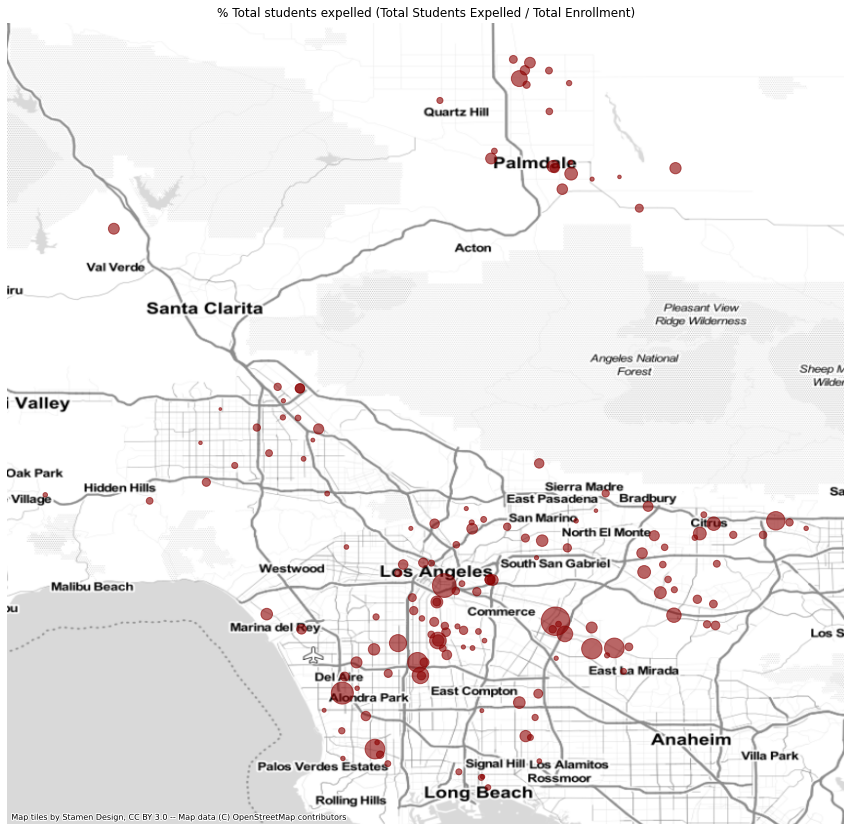

In [52]:
# map
sub_gdf = expgdf_final[expgdf_final.ReportingCategory == 'TA']

ax = sub_gdf.plot(figsize=(15,15), 
                markersize=40000*sub_gdf.Pct_ExpR_EnrR,
                color='darkred',
                alpha = 0.6)

# title (including count)
ax.set_title('% Total students expelled (Total Students Expelled / Total Enrollment)')

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.Stamen.TonerLite)

2. % Total students expelled who are Black (Black students expelled / TA students expelled)

and repeat for all groups!

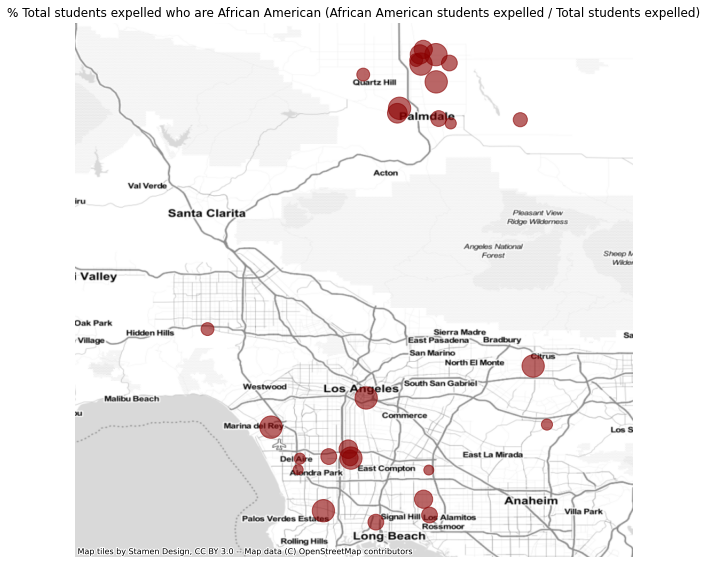

In [67]:
# dictionary in which the key is the Reporting Category Code, and the value is the associated descriptive string 
RC_strings_lookup = {"RB" : "African American",
                     "RI" : "American Indian or Alaska Native",
                     "RA" : "Asian", 
                     "RF" : "Filipino", 
                     "RH" : "Hispanic or Latino",
                     "RD" : "Not Reported",
                     "RP" : "Pacific Islander",
                     "RT" : "Two or More Races",
                     "RW" : "White"
                    }

# create a function that will plot based on the 
def plot_ExpR_ExpTA_by_race(RC='RB', multiplier = 500):
    
    sub_gdf = expgdf_final[expgdf_final.ReportingCategory == RC]
    ax = sub_gdf.plot(figsize=(10,10), 
                      markersize=multiplier*sub_gdf.Pct_ExpR_ExpTA,
                      color='darkred',
                      alpha = 0.6)

    # title (including count)

    ax.set_title('% Total students expelled who are '
                 + RC_strings_lookup[RC] + ' (' + RC_strings_lookup[RC]
                 + ' students expelled / Total students expelled)')

    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,
                    crs='epsg:4326', 
                    source=ctx.providers.Stamen.TonerLite)

plot_ExpR_ExpTA_by_race()

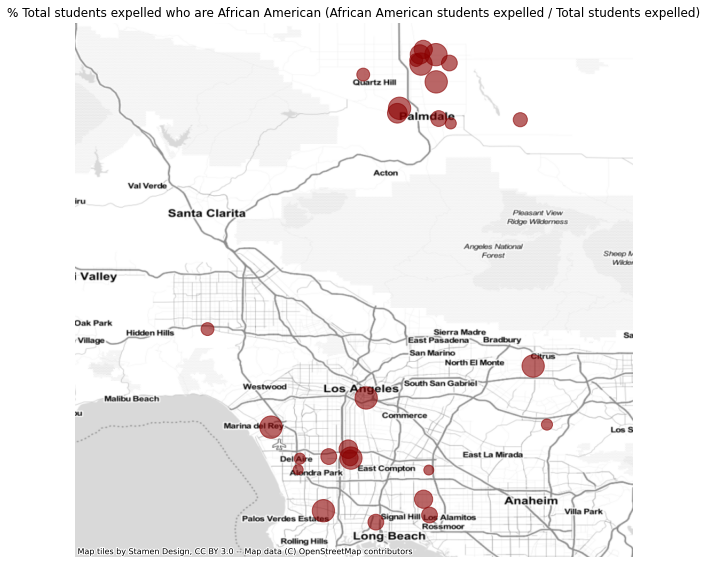

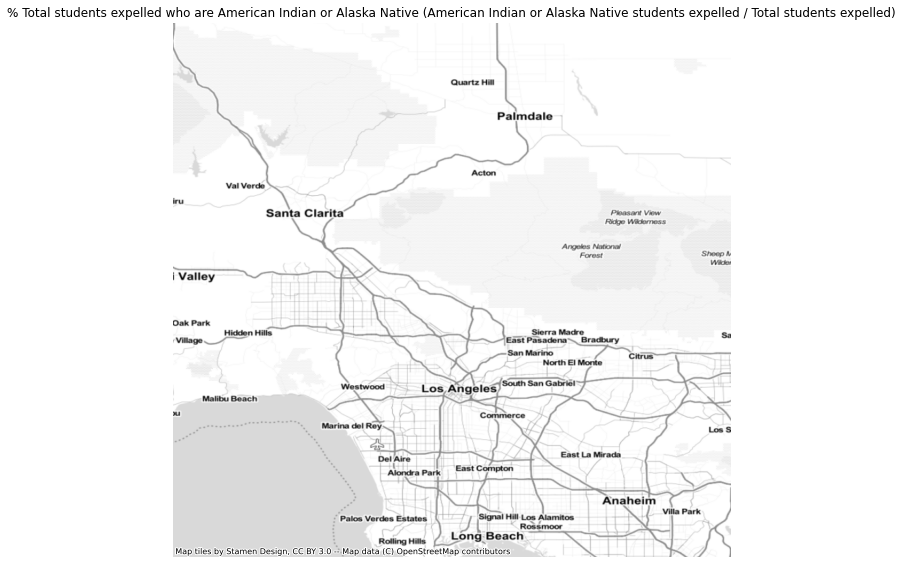

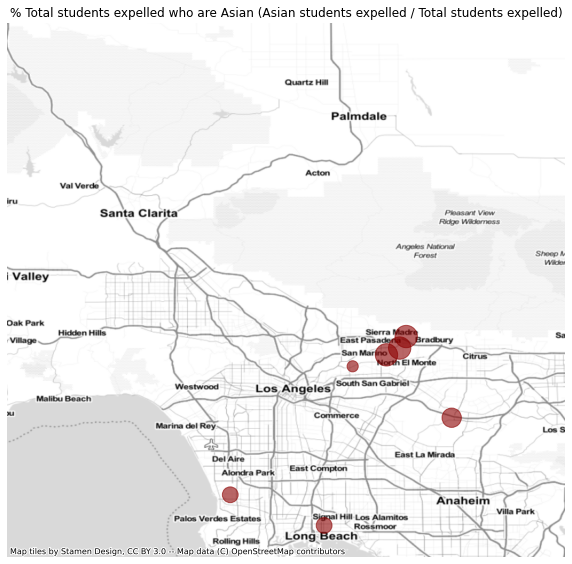

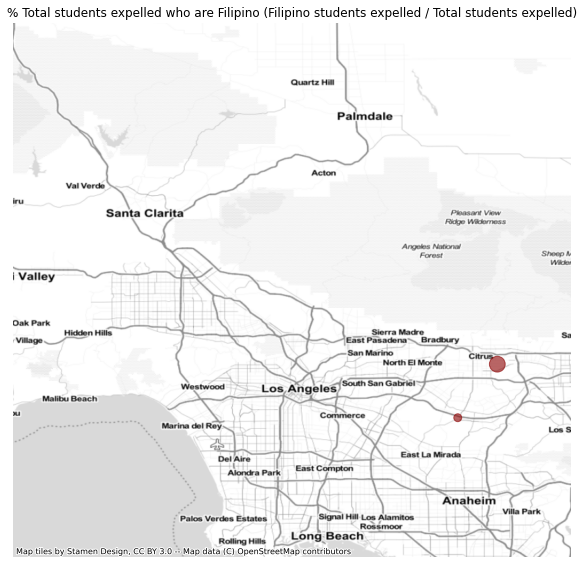

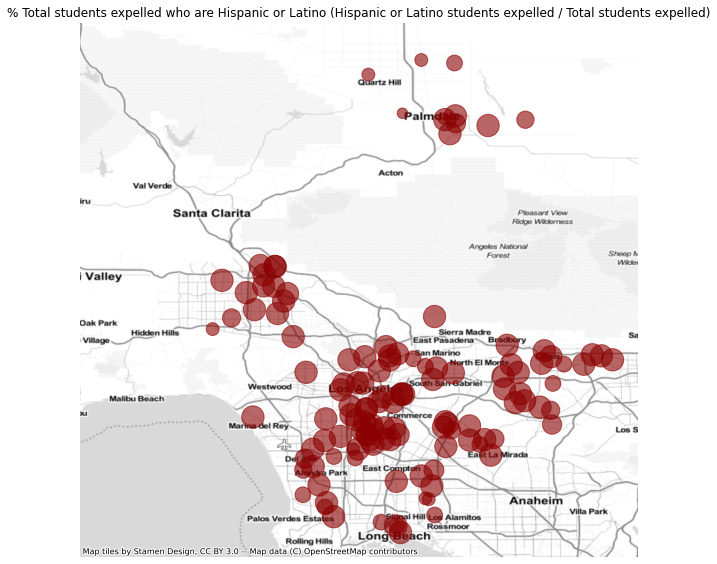

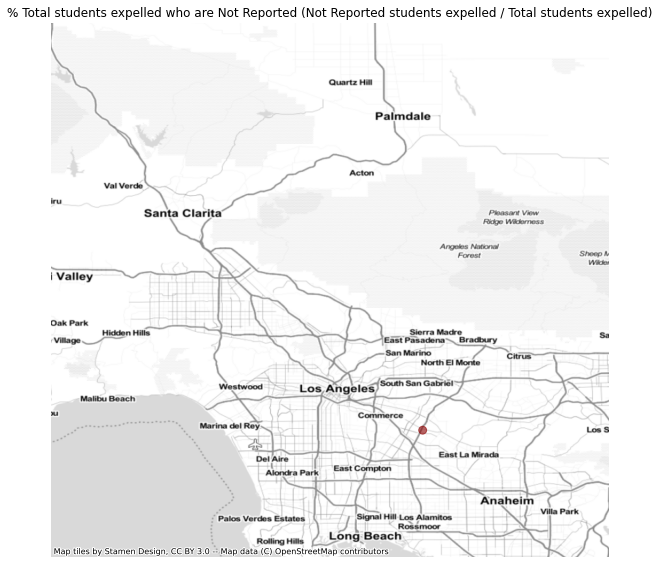

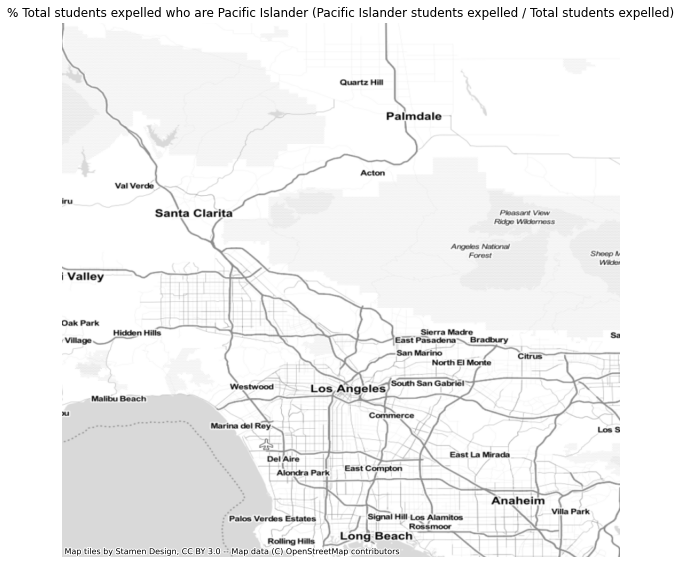

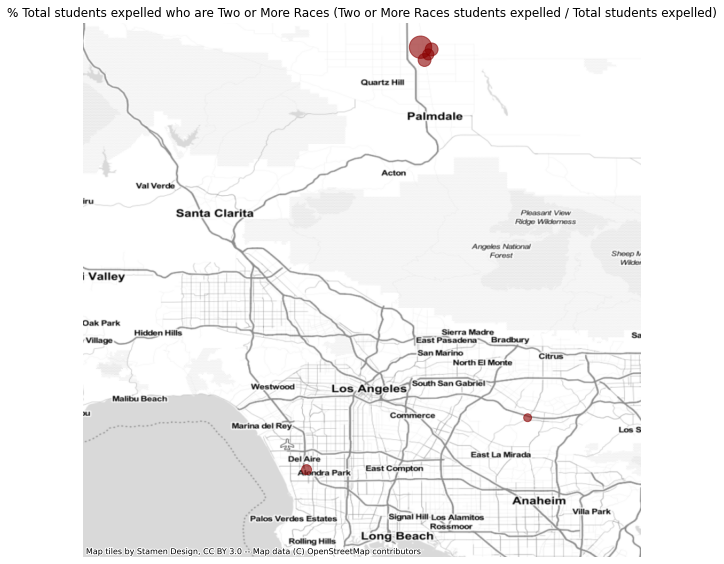

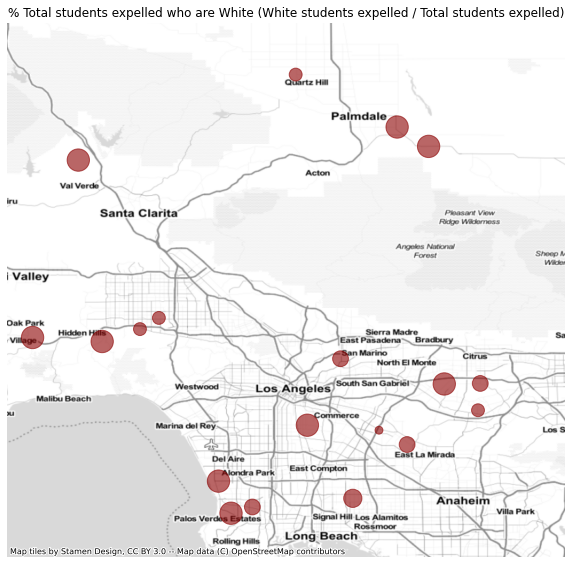

In [68]:
# loop through all racial reporting categories
for _rc in RC_strings_lookup.keys():
    plot_ExpR_ExpTA_by_race(RC = _rc)

3. % of Black students who are expelled (Black students expelled / Black enrollment)

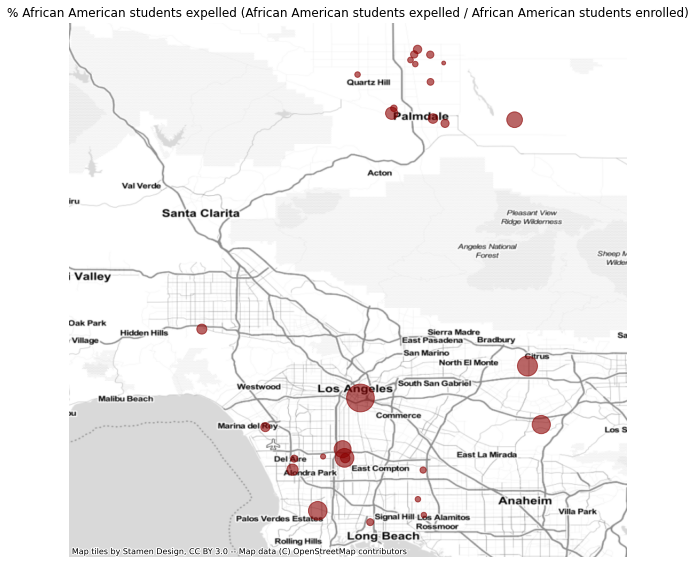

In [82]:
# create a function that will plot based on the 
def plot_ExpR_EnrR_by_race(RC='RB', multiplier = 10000):
    
    sub_gdf = expgdf_final[expgdf_final.ReportingCategory == RC]
    ax = sub_gdf.plot(figsize=(10,10), 
                      markersize=multiplier*sub_gdf.Pct_ExpR_EnrR,
                      color='darkred',
                      alpha = 0.6)

    # title (including count)

    ax.set_title('% ' + RC_strings_lookup[RC] + ' students expelled'
                 + ' (' + RC_strings_lookup[RC]
                 + ' students expelled / ' + RC_strings_lookup[RC] + ' students enrolled)')

    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,
                    crs='epsg:4326', 
                    source=ctx.providers.Stamen.TonerLite)

plot_ExpR_EnrR_by_race()

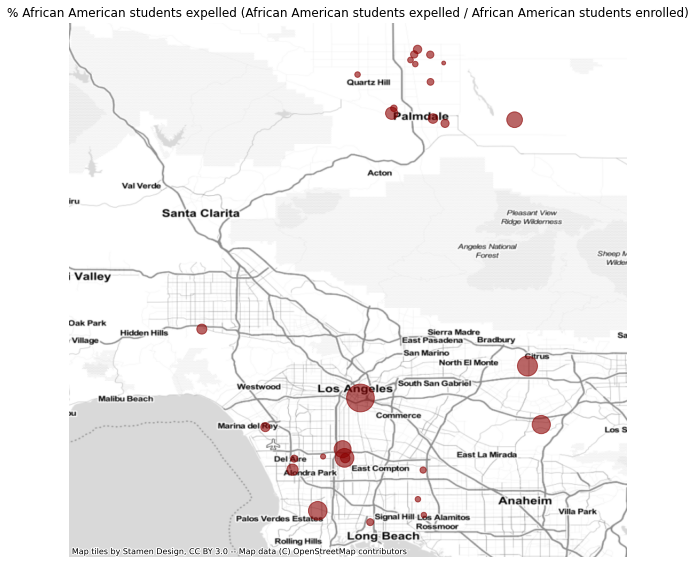

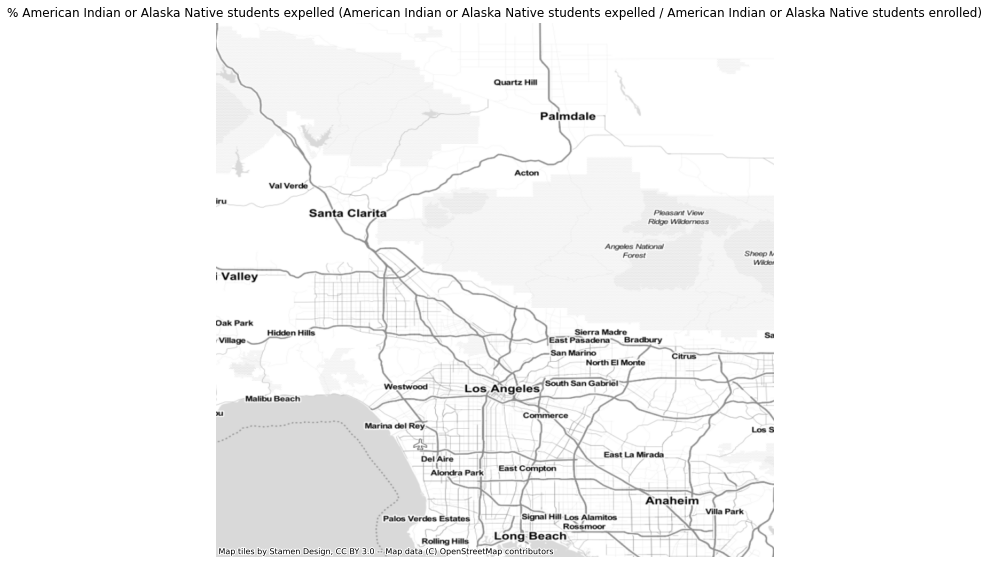

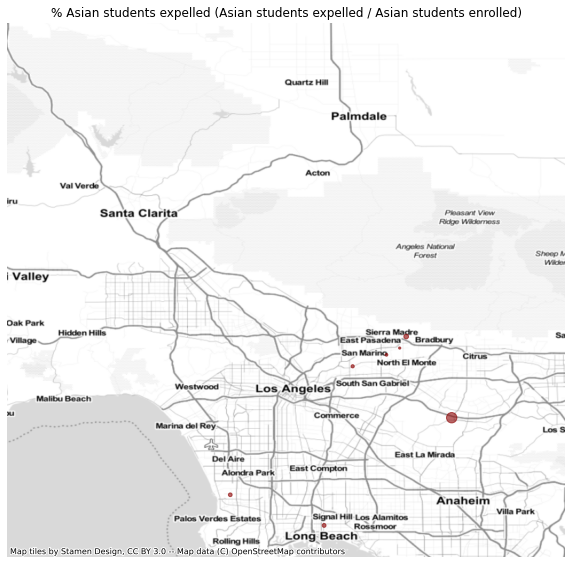

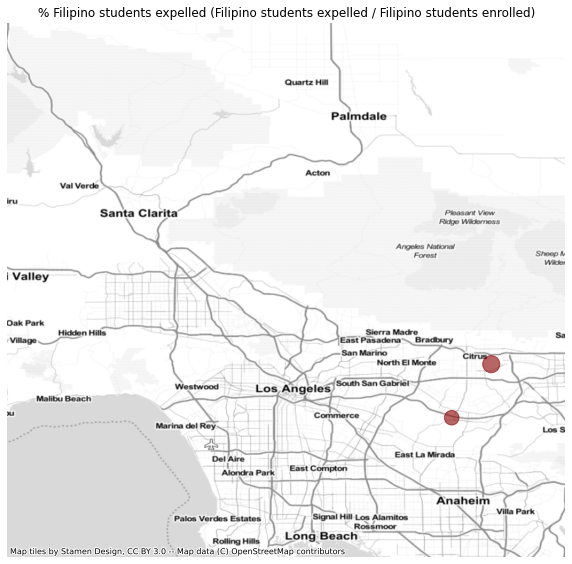

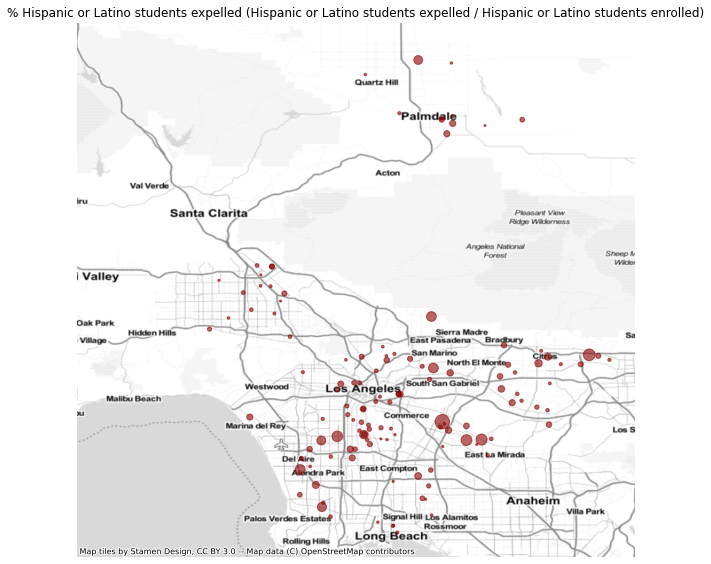

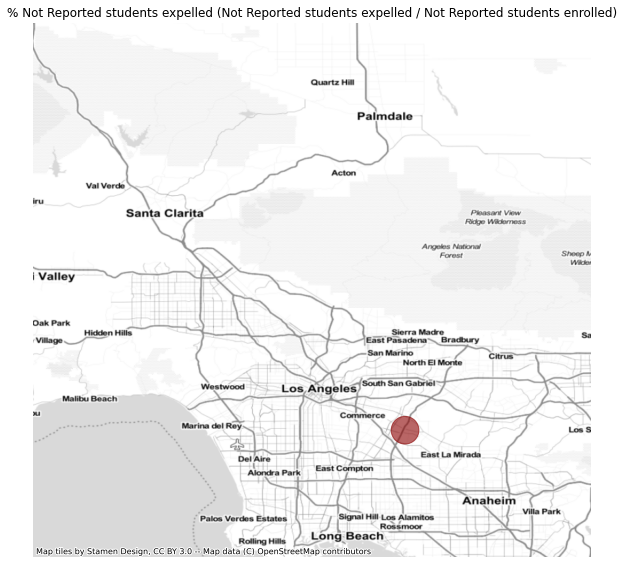

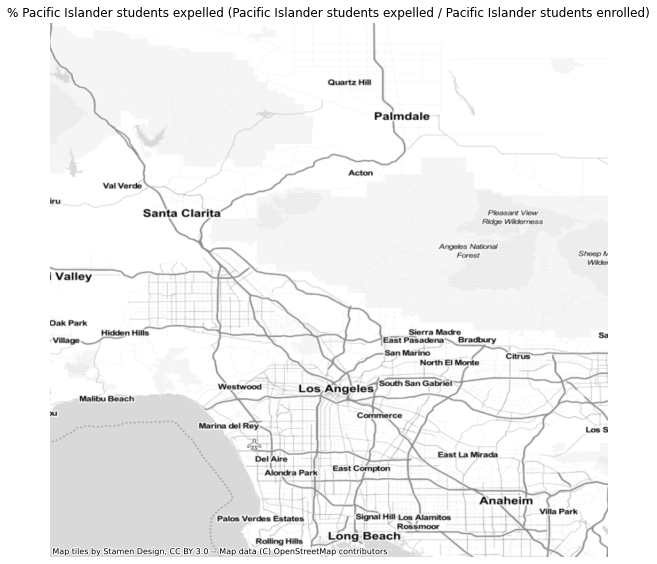

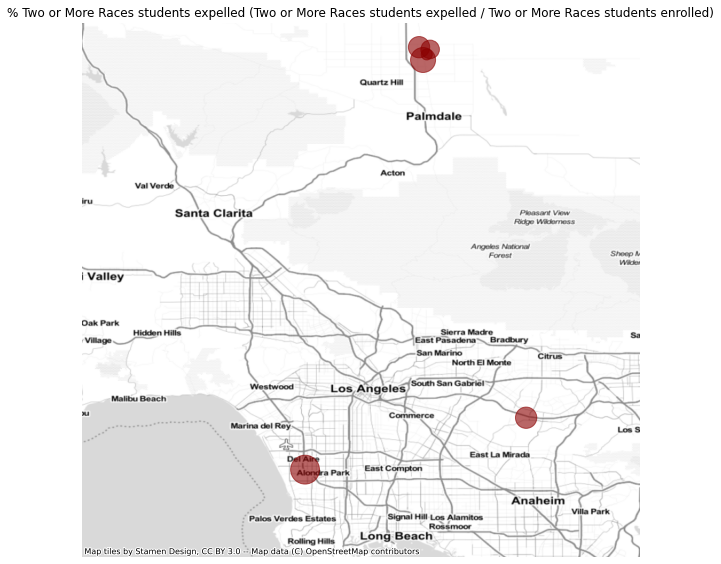

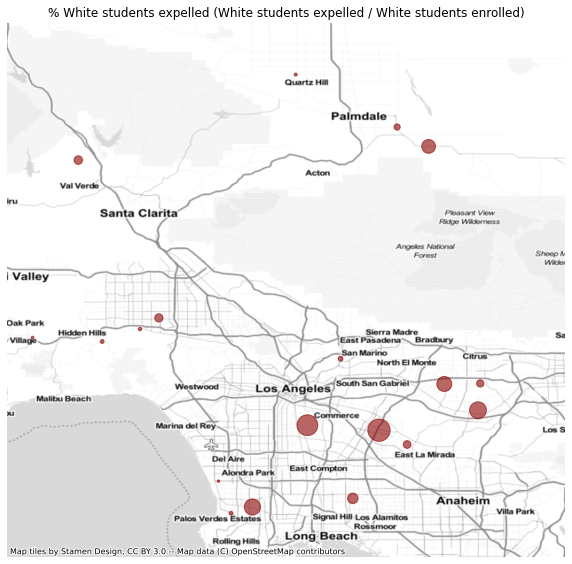

In [83]:
# loop through all racial reporting categories
for _rc in RC_strings_lookup.keys():
    plot_ExpR_EnrR_by_race(RC = _rc)

When we look at the expulsions by race, we see different spatial patterns.
For example, black students seem to be clustered in fewer schools at high proportions, whereas expelled hispanic students are distributed throughout schools in LA County more evenly. We will explore these spatial patterns through KDE maps, and centrography analysis. 

## Spatial Analysis
### KDE map
Through a KDE map, we will observe the distribution of schools that expelled students of one of the following races. 

In [76]:
# joint plot
# create a subset of the data
expgdf_HBW = expgdf_final[(expgdf_final.ReportingCategory.isin(['RH','RB','RW'])) & (expgdf_final['Total Expulsions_R']>0)]

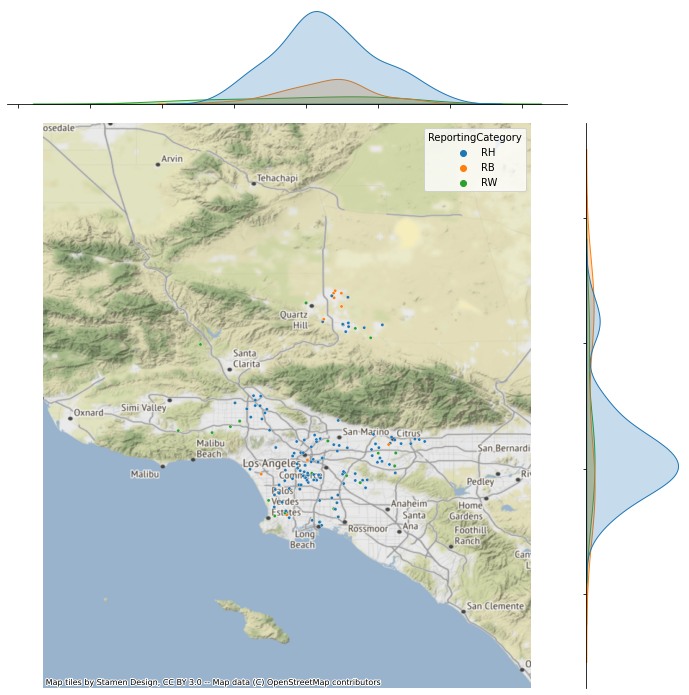

In [77]:
# color code by race
g = sns.jointplot(data = expgdf_HBW,
                  x=expgdf_HBW.geometry.x, 
                  y=expgdf_HBW.geometry.y,
                  hue='ReportingCategory',
                  s=10,
                  height=10 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')